In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, Dropout, Activation
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Deconv2D
from keras.layers import merge
from keras.models import Model
from keras import backend as K_backend
from keras import objectives
from keras.utils import np_utils

from keras_tqdm import TQDMNotebookCallback

Using TensorFlow backend.


In [2]:
def draw_digit(generator, z_sample, digit_size = 28, n=1):
    z_sample = np.array(z_sample).reshape(1,2)
    figure = np.zeros((digit_size * n, digit_size * n))
    x_decoded = generator.predict(z_sample)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    i, j = 0,0
    figure[i * digit_size: (i + 1) * digit_size,
           j * digit_size: (j + 1) * digit_size] = digit
    plt.figure(figsize=(2, 2))
    plt.imshow(figure)
    plt.show()
    
def graph_digits(x_test_encoded, s=None, dims=(0,1), lim=None, figsize=(4,4), parity_color=False):
#     colors = ['silver', 'w', 'orange', 'lime', 'y', 'r', 'darkgreen', 'cyan', 'blue', 'darkviolet']     # synesthesia scheme
    colors = ['black', 'brown', 'red', 'cyan', 'blue', 'magenta', 'green', 'yellow', 'silver', 'violet' ]
    if parity_color:
        colors = ['blue', 'red',]*5
    plt.figure(figsize=figsize)
    plots =[]
    for digit in range(10):
        mask = y_test==digit
        xd, yd = dims
        plots.append(plt.scatter(x_test_encoded[:, xd][mask], x_test_encoded[:, yd][mask], s=s, c=colors[digit], alpha=0.5))
    ax = plt.gca()
    ax.legend(plots, range(10))
    plt.scatter(0,0, s=15, marker='*', c='k')
    plt.scatter(0,0, s=10, marker='*', c='y')

    if lim is not None:
        plt.xlim((-lim,lim))
        plt.ylim((-lim,lim))
    plt.show()
    

In [3]:
class Autoencoder2D(object):
    def __init__(self,
                 input_shape=(28, 28, 1),
                 latent_dim=2,  # Size of the encoded vector
                 batch_size=100): # size of minibatch
        self.model = None
        self.encoder = None
        self.generator = None
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.latent_dim = latent_dim

class VariationalAutoencoder2D(Autoencoder2D):
    def __init__(self,
                 input_shape=(28, 28, 1),
                 latent_dim=2,  # Size of the encoded vector
                 batch_size=100,  # size of minibatch
                 epsilon_std=1.0):  # This is the stddev for our normal-dist sampling of the latent vector):
        super().__init__(input_shape=input_shape, latent_dim=latent_dim, batch_size=batch_size)
        self.epsilon_std = epsilon_std
        self.z_mean = Dense(latent_dim)
        self.z_log_var = Dense(latent_dim)

        # input image dimensions
        self.input_shape = input_shape
        if len(input_shape) == 3:
            self.img_rows, self.img_cols, self.img_chns = input_shape
        elif len(input_shape) == 2:
            self.img_rows, self.img_cols = input_shape
            self.img_chns = 1
        else:
            raise ValueError("Invalid input shape: {}".format(input_shape))


    def sampling(self, args):
        # Forging our latent vector from the reparameterized mean and std requires some sampling trickery
        # that admittedly I do not understand in the slightest at this point in time
        z_mean, z_log_var = args
        epsilon = K_backend.random_normal(shape=(self.batch_size, self.latent_dim),
                                          mean=0., stddev=self.epsilon_std)
        return z_mean + K_backend.exp(z_log_var) * epsilon

    def vae_loss(self, x, x_decoded_mean):
        # Custom loss function for VAE. More VAE voodoo
        # FC: NOTE: binary_crossentropy expects a batch_size by dim
        # FC: for x and x_decoded_mean, so we MUST flatten these!
        x = K_backend.flatten(x)
        x_decoded_mean = K_backend.flatten(x_decoded_mean)
        xent_loss = self.img_rows * self.img_cols * objectives.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K_backend.mean(
            1 + self.z_log_var - K_backend.square(self.z_mean) - K_backend.exp(self.z_log_var), axis=-1)
        # Kullback–Leibler divergence. so many questions about this one single line
        return xent_loss + kl_loss



class Crossfire_MNIST_0(VariationalAutoencoder2D):
    """ Covolutional VAE with a "crossfire" component - a classifier is bolted onto the end of the encoder
    and loss function can be parameterized to function from classifier loss instead of autoencoder loss.
    Ideally, the model starts in pure autoencoder mode to learn features, then as loss flattens out, the
    network starts weighing classifier loss progressively greater """

    def __init__(self,
                 input_shape=(28, 28, 1),
                 latent_dim=2,  # Size of the encoded vector
                 n_classes=10,  # number of classes in dataset
                 batch_size=100,  # size of minibatch
                 n_stacks=3,  # Number of convolayers to stack, this boosts performance of the network dramatically
                 intermediate_dim=256,  # Size of the dense layer after convs
                 n_filters=64,  # Number of filters in the first layer
                 px_conv=3,  # Default convolution window size
                 dropout_p=0.1,  # Default dropout rate
                 epsilon_std=1.0,  # This is the stddev for our normal-dist sampling of the latent vector
                 ):

        # This is my original crossfire network, and it works. As such, it has apprentice marks all over
        # Reconstructing as-is before tinkering
        # Based heavily on https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder_deconv.py
        # and https://groups.google.com/forum/#!msg/keras-users/iBp3Ngxll3k/_GbY4nqNCQAJ

        super().__init__(input_shape=input_shape, latent_dim=latent_dim, batch_size=batch_size, epsilon_std=epsilon_std)



        # theano vs tensorflow ordering of size parameters
        if K_backend.image_dim_ordering() == 'th':
            self.original_img_size = (self.img_chns, self.img_rows, self.img_cols)
        else:
            self.original_img_size = (self.img_rows, self.img_cols, self.img_chns)


        # experimental
        def_conv = {'border_mode': 'same', 'activation': 'relu'}

        # Convolutional frontend filters as per typical convonets
        x_in = Input(batch_shape=(batch_size,) + self.original_img_size, name='main_input')
        conv_1 = x_in
        conv_1 = Conv2D(n_filters, px_conv, px_conv, border_mode='same', activation='relu')(conv_1)
        conv_2 = Conv2D(n_filters, px_conv, px_conv, border_mode='same', activation='relu',
                        subsample=(2, 2))(conv_1)
        stack = Conv2D(n_filters, px_conv, px_conv, border_mode='same', activation='relu',
                       name='stack_base')(conv_2)

        # I call this structure the "stack". By stacking convo layers w/ BN and dropout, the performance
        # of the network increases dramatically. For MNIST, I like n_stacks=3.
        # Presumably, the deepness allows for greater richness of filters to emerge
        for i in range(n_stacks):
            stack = BatchNormalization()(stack)
            stack = Dropout(dropout_p)(stack)
            stack = Conv2D(n_filters, px_conv, px_conv, border_mode='same', activation='relu',
                           name='stack_{}'.format(i), subsample=(1, 1))(stack)

        stack = BatchNormalization()(stack)
        conv_4 = Conv2D(n_filters, px_conv, px_conv, border_mode='same', activation='relu')(stack)

        # Densely connected layer after the filters
        flat = Flatten()(conv_4)
        hidden_1 = Dense(intermediate_dim, activation='relu', name='intermezzo')(flat)

        # This is the Variational Autoencoder reparameterization trick
        zed = Dense(latent_dim)(hidden_1)
        alpha = Lambda(lambda x: x[:,0:1], name='AlphaKeyVar')(zed) # output_shape=(1,) + input_shape[2:]
        beta = Lambda(lambda x: x[:,1:], name='BetaResidualVar')(zed) # output_shape=(1,) + input_shape[2:]
        z_mean = merge([alpha, beta], mode='concat')
        z_log_var = Dense(latent_dim)(hidden_1)
        
#         zed = Lambda(lambda x: x[:,0,:,:], output_shape=(1,) + input_shape[2:])(z_mean)
#         zed = z_mean[:, 0]

        # Make these instance vars so X-Ent can use them. Probably a better way out there
        self.z_mean = z_mean
        self.z_log_var = z_log_var
        self.zed = zed

        # Part 2 of the reparam trick is sample from the mean-vec and std-vec (log_var). To do this, we utilize a
        # custom layer via Lambda class to combine the mean and log_var outputs and a custom sampling function
        # 'z' is our latent vector
        z = Lambda(self.sampling, output_shape=(latent_dim,), name='latent_z')([z_mean, z_log_var])

        # This marks the end of the encoding portion of the VAE

        # The 'classer' is a subnet after the latent vector, which will drive the distribution in order to
        # (hopefully) provide better generalization in classification
        # Note: in the original Crossfile I attach this layer to z_mean, rather than z, for reasons I cannot recall
        # I suspect this is because for classification, we do not care about the variance, just the mean of the vec
        # In this setup, we go straight to one-hot
        # Original uses normal init. Could try glorot or he_normal
        # todo: test behavior of attachment point of the classer, different inits
        classer_base = Dense(n_classes, init='normal', activation='softmax', name='classer_output')(self.z_mean)
        #         classer_base = Dense(n_classes, init='normal', activation='softmax', name='classer_output')(z)

        batch_size_dec = batch_size

        # On to Decoder. we instantiate these layers separately so as to reuse them later
        # e.g. for feeding in latent-space vectors, or (presumably) inspecting output
        decoder_hidden = Dense(intermediate_dim, activation='relu')
        decoder_upsample = Dense(n_filters * 14 * 14, activation='relu')

        if K_backend.image_dim_ordering() == 'th':
            output_shape = (batch_size_dec, n_filters, 14, 14)
        else:
            output_shape = (batch_size_dec, 14, 14, n_filters)

        decoder_reshape = Reshape(output_shape[1:])  # FC's, I don't understand why this is here

        # FC uses Deconv, but another example uses UpSample layers. See Keras Api: Deconvolution2D
        decoder_deconv_1 = Deconv2D(n_filters, px_conv, px_conv, output_shape,
                                    border_mode='same', activation='relu')
        decoder_deconv_2 = Deconv2D(n_filters, px_conv, px_conv, output_shape,
                                    border_mode='same', activation='relu')

        # Some more reshaping, presumably I need to modify this in order to use different shapes
        if K_backend.image_dim_ordering() == 'th':
            output_shape = (batch_size_dec, n_filters, 29, 29)
        else:
            output_shape = (batch_size_dec, 29, 29, n_filters)

        # more FC voodoo
        decoder_deconv_3_upsamp = Deconv2D(n_filters, 2, 2, output_shape, border_mode='valid', subsample=(2, 2),
                                           activation='relu')
        decoder_mean_squash = Conv2D(self.img_chns, 2, 2, border_mode='valid', activation='sigmoid', name='main_output')

        # Now, piecemeal the encoder together. IDK why this is done this manner, and not functional like the
        # encoder half. presumably, this is so we can inspect the output at each point
        hid_decoded = decoder_hidden(z)
        up_decoded = decoder_upsample(hid_decoded)
        reshape_decoded = decoder_reshape(up_decoded)
        deconv_1_decoded = decoder_deconv_1(reshape_decoded)
        deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
        x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
        x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)

        # FC: build a digit generator that can sample from the learned distribution
        # todo: (un)roll this
        decoder_input = Input(shape=(latent_dim,))
        _hid_decoded = decoder_hidden(decoder_input)
        _up_decoded = decoder_upsample(_hid_decoded)
        _reshape_decoded = decoder_reshape(_up_decoded)
        _deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
        _deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
        _x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
        _x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)

        # Now we create the actual models. We also compile them automatically, this could be isolated later
        # Primary model - VAE
        self.model = Model(x_in, x_decoded_mean_squash)
        self.model.compile(optimizer='rmsprop', loss=self.vae_loss)
        
        self.zedmodel = Model(x_in, zed)
        self.zedmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        # Crossfire network
        self.classifier = Model(x_in, classer_base)
        self.classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        # Ok, now comes the tricky part. See these references:
        # https://keras.io/getting-started/functional-api-guide/#multi-input-and-multi-output-models
        # I believe the names have to match the layer names, but are otherwise arbitrary
        self.crossmodel = Model(input=x_in, output=[x_decoded_mean_squash, classer_base])
        self.crossmodel.compile(optimizer='rmsprop',
                                loss={'main_output': self.vae_loss, 'classer_output': 'categorical_crossentropy'},
                                loss_weights={'main_output': 1.0, 'classer_output': 5.0})

        # build a model to project inputs on the latent space
        self.encoder = Model(x_in, self.z_mean)
        # reconstruct the digit pictures from latent space
        self.generator = Model(decoder_input, _x_decoded_mean_squash)



    def fit_crossmodel(self, x_dict, y_dict, batch_size=None, nb_epoch=10, verbose=1, callbacks=[], validation_split=0.,
                       validation_data=None, shuffle=True, class_weight=None, sample_weight=None):
        callbacks_history = self.crossmodel.fit(x_dict, y_dict, batch_size, nb_epoch, verbose, callbacks,
                                                validation_split,
                                                validation_data, shuffle, class_weight, sample_weight)
        return callbacks_history

In [4]:
class Autoencoder(object):
    """
    Base class for all-purpose autoencoder. VAE, CNN-AE, etc will be built off of this.

    Input -> Encoder -> Z Latent Vector -> Decoder -> Output
    """
    def __init__(self,
                 input_shape=(28, 28, 1),
                 latent_dim=2,  # Size of the encoded vector
                 batch_size=100, # size of minibatch
                 compile_decoder=False # create the decoder. Not necessary for every use case
                 ):
        self.model = None
        self.encoder = None
        self.decoder = None
        self.batch_size = batch_size
        self.latent_dim = latent_dim
        self.compile_decoder = compile_decoder
        assert K_backend.image_dim_ordering() == 'tf', 'Cannot support Theano ordering! Use TF ordering! #tensorflowmasterrace'

        # input image dimensions
        self.input_shape = input_shape
        # self.data_shape = input_shape[1:] # Shape of a single sample
        if len(input_shape) == 4:
            self.img_rows, self.img_cols, self.img_stacks, self.img_chns = input_shape
        elif len(input_shape) == 3:
            self.img_rows, self.img_cols, self.img_chns = input_shape
        elif len(input_shape) == 2:
            self.img_rows, self.img_cols = input_shape
            self.img_chns = 1
        elif len(input_shape) == 1:
            self.img_rows = input_shape[0]  # todo: test this
        else:
            raise ValueError("Invalid input shape: {}".format(input_shape))

    def rollup_decoder(self, z, z_input, layers_list):
        """
        Takes a list of Keras layers and returns the decoder back-half and the standalone decoder model
        :param z: Layer corresponding to the latent space vector
        :param z_input: Layer corresponding to the decoder input
        :param layers_list: List of layers to roll up
        :return:
        """
        last_ae = z
        last_dc = z_input
        for i, layer in enumerate(layers_list):
            #             if i ==0:
            last_ae = layer(last_ae)
            if self.compile_decoder:
                last_dc = layer(last_dc)
        return last_ae, last_dc


class VAE(Autoencoder):
    """
    Variational Autoencoder.
    """
    def __init__(self,
                 input_shape=(28, 28, 1),
                 latent_dim=2,  # Size of the encoded vector
                 batch_size=100,  # size of minibatch
                 epsilon_std=1.0, # This is the stddev for our normal-dist sampling of the latent vector
                 compile_decoder=False
                 ):
        super().__init__(input_shape=input_shape, latent_dim=latent_dim, batch_size=batch_size,
                         compile_decoder=compile_decoder)
        # Necessary to instantiate this as instance variables such that they can be passed to the loss function (internally), since loss functions are
        # all of the form lossfn(y_true, y_pred)
        self.epsilon_std = epsilon_std
        self.z_mean = Dense(latent_dim)
        self.z_log_var = Dense(latent_dim)



    def sampling(self, args):
        """
        This is what makes the variational technique happen.
        :param args:
        :return:
        """
        # Forging our latent vector from the reparameterized mean and std requires some sampling trickery
        # that admittedly I do not understand in the slightest at this point in time
        z_mean, z_log_var = args
        epsilon = K_backend.random_normal(shape=(self.batch_size, self.latent_dim),
                                          mean=0., stddev=self.epsilon_std)
        # We return z_mean + epsilon*sigma^2. Not sure why we use log var
        # Basically, create a random variable vector from the distribution
        # We are learning a distribution (mu, var) which represents the input
        return z_mean + K_backend.exp(z_log_var) * epsilon

    def vae_loss(self, x, x_decoded_mean):
        """
        Custom loss function for VAE. Uses Kullback-Leibler divergence.

        Notes from fchollet: binary_crossentropy expects a shape (batch_size, dim) for x and x_decoded_mean,
        so we MUST flatten these!
        :param x:
        :param x_decoded_mean:
        :return:
        """

        x = K_backend.flatten(x)
        x_decoded_mean = K_backend.flatten(x_decoded_mean)
        shape_coef = np.product(self.input_shape)
        xent_loss = shape_coef * objectives.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K_backend.mean(
            1 + self.z_log_var - K_backend.square(self.z_mean) - K_backend.exp(self.z_log_var), axis=-1)
        # Kullback–Leibler divergence. so many questions about this one single line
        return xent_loss + kl_loss


class VAE_MNIST_0(VAE):
    """ Covolutional VAE for MNIST. Should work for other things, but untested """

    def __init__(self,
                 input_shape=(28, 28, 1),
                 latent_dim=2,  # Size of the encoded vector
                 n_classes=10,  # number of classes in dataset
                 batch_size=100,  # size of minibatch
                 n_stacks=3,  # Number of convolayers to stack, this boosts performance of the network dramatically
                 intermediate_dim=256,  # Size of the dense layer after convs
                 n_filters=64,  # Number of filters in the first layer
                 px_conv=3,  # Default convolution window size
                 dropout_p=0.1,  # Default dropout rate
                 epsilon_std=1.0,  # This is the stddev for our normal-dist sampling of the latent vector
                 compile_decoder=True,
                 ):

        # This is my original crossfire network, and it works. As such, it has apprentice marks all over
        # Reconstructing as-is before tinkering
        # Based heavily on https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder_deconv.py
        # and https://groups.google.com/forum/#!msg/keras-users/iBp3Ngxll3k/_GbY4nqNCQAJ

        super().__init__(input_shape=input_shape, latent_dim=latent_dim, batch_size=batch_size, epsilon_std=epsilon_std,
                         compile_decoder=compile_decoder)



        # Convolutional frontend filters as per typical convonets
        print(self.input_shape)
        x_in = Input( self.input_shape, name='main_input') # batch_shape=(batch_size,) +
        conv_1 = x_in
        conv_1 = Conv2D(n_filters, px_conv, px_conv, border_mode='same', activation='relu')(conv_1)
        conv_2 = Conv2D(n_filters, px_conv, px_conv, border_mode='same', activation='relu',
                        subsample=(2, 2))(conv_1)
        stack = Conv2D(n_filters, px_conv, px_conv, border_mode='same', activation='relu',
                       name='stack_base')(conv_2)

        # I call this structure the "stack". By stacking convo layers w/ BN and dropout, the performance
        # of the network increases dramatically. For MNIST, I like n_stacks=3.
        # Presumably, the deepness allows for greater richness of filters to emerge
        for i in range(n_stacks):
            stack = BatchNormalization()(stack)
            stack = Dropout(dropout_p)(stack)
            stack = Conv2D(n_filters, px_conv, px_conv, border_mode='same', activation='relu',
                           name='stack_{}'.format(i), subsample=(1, 1))(stack)

        stack = BatchNormalization()(stack)
        conv_4 = Conv2D(n_filters, px_conv, px_conv, border_mode='same', activation='relu')(stack)

        # Densely connected layer after the filters
        flat = Flatten()(conv_4)
        hidden_1 = Dense(intermediate_dim, activation='relu', name='intermezzo')(flat)

        # This is the Variational Autoencoder reparameterization trick
#         hidden_2 = Dense(latent_dim, activation='sigmoid', name='hidden2')(hidden_1)
        
        z_mean = Dense(latent_dim, name='z_mean')(hidden_1)
#         z_mean = hidden_2

        z_log_var = Dense(latent_dim, name='z_log_var')(hidden_1)
        alpha = Lambda(lambda x: x[:,0:1], name='alpha_var')(hidden_1) # output_shape=(1,) + input_shape[2:]
        alpha = Activation('sigmoid', name='alpha_output')(alpha)
#         alpha = Dense(2, activation='sigmoid', name='alpha_output')(alpha)
        beta = Lambda(lambda x: x[:,1:], name='BetaResidualVar')(z_mean) # output_shape=(1,) + input_shape[2:]
        
        z_merge = merge([alpha, beta], mode='concat')


        # Make these instance vars so X-Ent can use them. Probably a better way out there
        self.z_mean = z_mean
        self.z_log_var = z_log_var
        self.z_merge = z_merge
        self.alpha = alpha

        # Part 2 of the reparam trick is sample from the mean-vec and std-vec (log_var). To do this, we utilize a
        # custom layer via Lambda class to combine the mean and log_var outputs and a custom sampling function
        # 'z' is our latent vector
        z = Lambda(self.sampling, output_shape=(latent_dim,), name='latent_z')([z_mean, z_log_var])

        # This marks the end of the encoding portion of the VAE

        # The 'classer' is a subnet after the latent vector, which will drive the distribution in order to
        # (hopefully) provide better generalization in classification
        # Note: in the original Crossfile I attach this layer to z_mean, rather than z, for reasons I cannot recall
        # I suspect this is because for classification, we do not care about the variance, just the mean of the vec
        # In this setup, we go straight to one-hot
        # Original uses normal init. Could try glorot or he_normal
        # todo: test behavior of attachment point of the classer, different inits
        classer_base = Dense(n_classes, init='normal', activation='softmax', name='classer_output')(self.z_mean)
        #         classer_base = Dense(n_classes, init='normal', activation='softmax', name='classer_output')(z)

        batch_size_dec = batch_size

        # On to Decoder. we instantiate these layers separately so as to reuse them later
        # e.g. for feeding in latent-space vectors, or (presumably) inspecting output
        decoder_hidden = Dense(intermediate_dim, activation='relu')
        decoder_upsample = Dense(n_filters * 14 * 14, activation='relu')


        output_shape = (batch_size_dec, 14, 14, n_filters)

        decoder_reshape = Reshape(output_shape[1:])  # FC's, I don't understand why this is here

        # FC uses Deconv, but another example uses UpSample layers. See Keras Api: Deconvolution2D
        decoder_deconv_1 = Deconv2D(n_filters, px_conv, px_conv, output_shape,
                                    border_mode='same', activation='relu')
        decoder_deconv_2 = Deconv2D(n_filters, px_conv, px_conv, output_shape,
                                    border_mode='same', activation='relu')

        # Some more reshaping, presumably I need to modify this in order to use different shapes
        output_shape = (batch_size_dec, 29, 29, n_filters)

        # more FC voodoo
        decoder_deconv_3_upsamp = Deconv2D(n_filters, 2, 2, output_shape, border_mode='valid', subsample=(2, 2),
                                           activation='relu')
        decoder_mean_squash = Conv2D(self.img_chns, 2, 2, border_mode='same', activation='sigmoid', name='main_output')

        # Now, piecemeal the encoder together. IDK why this is done this manner, and not functional like the
        # encoder half. presumably, this is so we can inspect the output at each point
        # hid_decoded = decoder_hidden(z)
        # up_decoded = decoder_upsample(hid_decoded)
        # reshape_decoded = decoder_reshape(up_decoded)
        # deconv_1_decoded = decoder_deconv_1(reshape_decoded)
        # deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
        # x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
        # x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)

        hid_decoded = decoder_hidden
        up_decoded = decoder_upsample
        reshape_decoded = decoder_reshape
        deconv_1_decoded = decoder_deconv_1
        deconv_2_decoded = decoder_deconv_2
        x_decoded_relu = decoder_deconv_3_upsamp
        x_decoded_mean_squash = decoder_mean_squash

        layers_list = [decoder_hidden, decoder_upsample, decoder_reshape, decoder_deconv_1, decoder_deconv_2,
                       decoder_deconv_3_upsamp, decoder_mean_squash]

        decoder_input = Input(shape=(latent_dim,))

        # todo: better naming convention
        ae, dc = self.rollup_decoder(z, decoder_input, layers_list)

        if self.compile_decoder:
            # FC: build a digit generator that can sample from the learned distribution
            # todo: (un)roll this
            _hid_decoded = decoder_hidden(decoder_input)
            _up_decoded = decoder_upsample(_hid_decoded)
            _reshape_decoded = decoder_reshape(_up_decoded)
            _deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
            _deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
            _x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
            _x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)

        # Now we create the actual models. We also compile them automatically, this could be isolated later
        # Primary model - VAE
        self.model = Model(x_in, ae)
        self.model.compile(optimizer='rmsprop', loss=self.vae_loss)
        
        self.zedmodel = Model(x_in, output=[ae, alpha])
        self.zedmodel.compile(optimizer='adam',
                              loss={'main_output': self.vae_loss, 'alpha_output': 'binary_crossentropy'},
                              loss_weights={'main_output': 1.0, 'alpha_output': 4.0},
                              metrics=['accuracy'])

        if True:

            # Crossfire network
            self.classifier = Model(x_in, classer_base)
            self.classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
            # Ok, now comes the tricky part. See these references:
            # https://keras.io/getting-started/functional-api-guide/#multi-input-and-multi-output-models
            # I believe the names have to match the layer names, but are otherwise arbitrary
            self.crossmodel = Model(input=x_in, output=[ae, classer_base])
            self.crossmodel.compile(optimizer='rmsprop',
                                    loss={'main_output': self.vae_loss, 'classer_output': 'categorical_crossentropy'},
                                    loss_weights={'main_output': 1.0, 'classer_output': 5.0})

        # build a model to project inputs on the latent space
        self.encoder = Model(x_in, self.z_mean)
        if self.compile_decoder:
            # reconstruct the digit pictures from latent space
            self.decoder = Model(decoder_input, dc)
            
    def fit_crossmodel(self, x_dict, y_dict, batch_size=None, nb_epoch=10, verbose=1, callbacks=[], validation_split=0.,
                       validation_data=None, shuffle=True, class_weight=None, sample_weight=None):
        callbacks_history = self.crossmodel.fit(x_dict, y_dict, batch_size, nb_epoch, verbose, callbacks,
                                                validation_split,
                                                validation_data, shuffle, class_weight, sample_weight)
        return callbacks_history

In [5]:
xf = VAE_MNIST_0()

(28, 28, 1)


/home/mike/ve/keras/lib/python3.5/site-packages/ipykernel/__main__.py:143: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
/home/mike/ve/keras/lib/python3.5/site-packages/ipykernel/__main__.py:145: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), strides=(2, 2), activation="relu", padding="same")`
/home/mike/ve/keras/lib/python3.5/site-packages/ipykernel/__main__.py:147: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), name="stack_base", padding="same", activation="relu")`
/home/mike/ve/keras/lib/python3.5/site-packages/ipykernel/__main__.py:156: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), strides=(1, 1), name="stack_0", padding="same", activation="relu")`
/home/mike/ve/keras/lib/python3.5/site-packages/ipykernel/__main__.py:156: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), strides=(1, 1), nam

In [6]:
xf.z_mean#[:, 0:]
xf.alpha

<tf.Tensor 'alpha_output/Sigmoid:0' shape=(?, 1) dtype=float32>

In [7]:
xf.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_input (InputLayer)          (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 28, 28, 64)    640                                          
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 14, 14, 64)    36928                                        
____________________________________________________________________________________________________
stack_base (Conv2D)              (None, 14, 14, 64)    36928                                        
___________________________________________________________________________________________

In [167]:
# train the VAE on MNIST digits
from keras.datasets import mnist
original_img_size = (28,28,1)
(x_train, y_train), (x_test, y_test) = mnist.load_data()
batch_size = 100
print(original_img_size)
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)

(28, 28, 1)


In [168]:
# one hot encode outputs
y_odd_train = np.bitwise_and(y_train, 1).reshape((-1,1))
y_odd_test = np.bitwise_and(y_test, 1).reshape((-1,1))
y_train_oh = np_utils.to_categorical(y_train)
y_test_oh = np_utils.to_categorical(y_test)
y_odd_train_oh = np_utils.to_categorical(y_odd_train)
y_odd_test_oh = np_utils.to_categorical(y_odd_test)

num_classes = y_test_oh.shape[1]
print(y_train.shape, y_test_oh.shape)
print('x_train.shape:', x_train.shape)
print('x_test.shape:', x_train.shape)
print('y_odd.shape:', y_odd_train.shape)
print('y_odd_oh.shape:', y_odd_train_oh.shape)


(60000,) (10000, 10)
x_train.shape: (60000, 28, 28, 1)
x_test.shape: (60000, 28, 28, 1)
y_odd.shape: (60000, 1)
y_odd_oh.shape: (60000, 2)


In [176]:

print('shapes: ', x_train.shape, x_test.shape)
xf.model.fit(x_train, x_train,
        shuffle=True,
        epochs=2,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        verbose=False,
        callbacks=[TQDMNotebookCallback()])

shapes:  (60000, 28, 28, 1) (10000, 28, 28, 1)


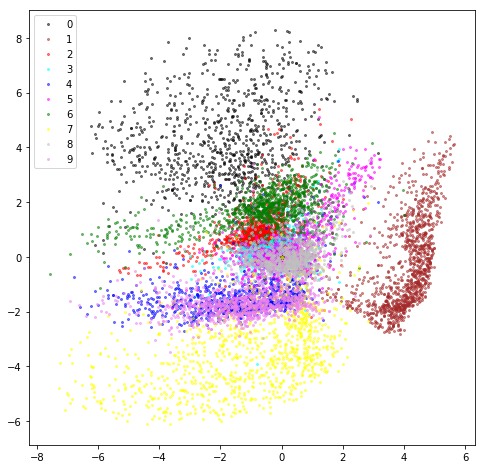

In [177]:
x_test_encoded = xf.encoder.predict(x_test, batch_size=batch_size)
graph_digits(x_test_encoded,s=4, figsize=(8,8))

In [178]:
xf.zedmodel.fit(x_train, {'main_output': x_train, 'alpha_output': y_odd_train}, 
        shuffle=True, batch_size=100, validation_data=(x_test, {'main_output':x_test, 'alpha_output':y_odd_test}), 
        nb_epoch=1,
        verbose=False,
        callbacks=[TQDMNotebookCallback()])

/home/mike/ve/keras/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


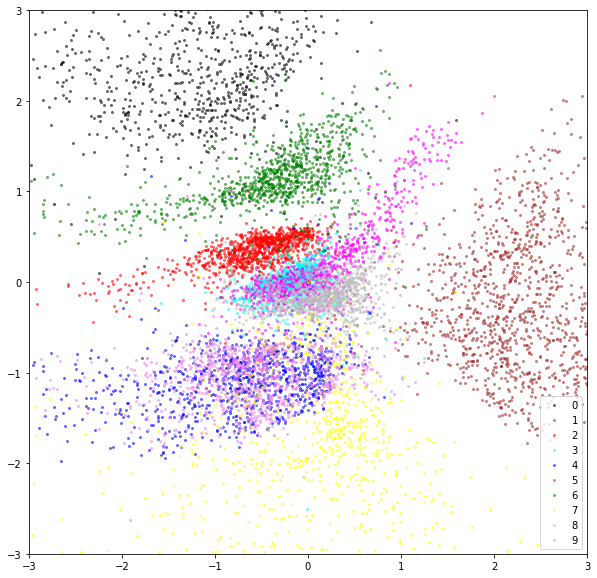

In [180]:
x_test_encoded = xf.encoder.predict(x_test, batch_size=batch_size)
graph_digits(x_test_encoded,s=4, lim=3, figsize=(10,10), parity_color=0)

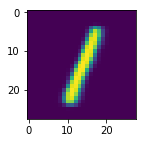

In [129]:
draw_digit(xf.decoder, (-1,1))

In [ ]:
xf.cr(x_train, {'main_output': x_train, 'classer_output': y_train_oh}, 
        shuffle=True, batch_size=100, validation_data=(x_test, {'main_output':x_test, 'classer_output':y_test_oh}), 
        nb_epoch=3,
        verbose=False,
        callbacks=[TQDMNotebookCallback()])